## Predicting Turbine Energy Yeild (TEY) using ambient variables

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from tensorflow import keras
from keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_11044/2355513383.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
#Import dataset
df = pd.read_csv('gas_turbines.csv')
df

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0      6.8594  1007.9  96.799  3.5000  19.663  1059.2  550.00  114.70  10.605   
1      6.7850  1008.4  97.118  3.4998  19.728  1059.3  550.00  114.72  10.598   
2      6.8977  1008.8  95.939  3.4824  19.779  1059.4  549.87  114.71  10.601   
3      7.0569  1009.2  95.249  3.4805  19.792  1059.6  549.99  114.72  10.606   
4      7.3978  1009.7  95.150  3.4976  19.765  1059.7  549.98  114.72  10.612   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
15034  9.0301  1005.6  98.460  3.5421  19.164  1049.7  546.21  111.61  10.400   
15035  7.8879  1005.9  99.093  3.5059  19.414  1046.3  543.22  111.78  10.433   
15036  7.2647  1006.3  99.496  3.4770  19.530  1037.7  537.32  110.19  10.483   
15037  7.0060  1006.8  99.008  3.4486  19.377  1043.2  541.24  110.74  10.533   
15038  6.9279  1007.2  97.533  3.4275  19.306  1049.9  545.85  111.58  10.583   

           CO     NOX  
0      3.1547  82.722  
1      3.2363  82.776  
2      3.2012  82.468  
3      3.1923  82.670  
4      3.2484  82.311  
...       ...     ...  
15034  4.5186  79.559  
15035  4.8470  79.917  
15036  7.9632  90.912  
15037  6.2494  93.227  
15038  4.9816  92.498  

[15039 rows x 11 columns]

### EDA and Visualization

In [3]:
df.isnull().any()

AT      False
AP      False
AH      False
AFDP    False
GTEP    False
TIT     False
TAT     False
TEY     False
CDP     False
CO      False
NOX     False
dtype: bool

In [4]:
df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

In [5]:
df.shape

(15039, 11)

In [6]:
df.dtypes

AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
NOX     float64
dtype: object

In [7]:
df.nunique()

AT      12086
AP        540
AH      12637
AFDP    11314
GTEP     8234
TIT       706
TAT      2340
TEY      4207
CDP      3611
CO      13096
NOX     11996
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [9]:
df[df.duplicated()].shape

(0, 11)

In [10]:
df[df.duplicated()]

Empty DataFrame
Columns: [AT, AP, AH, AFDP, GTEP, TIT, TAT, TEY, CDP, CO, NOX]
Index: []

In [11]:
df.describe()

AT           AP            AH          AFDP          GTEP  \
count  15039.000000  15039.00000  15039.000000  15039.000000  15039.000000   
mean      17.764381   1013.19924     79.124174      4.200294     25.419061   
std        7.574323      6.41076     13.793439      0.760197      4.173916   
min        0.522300    985.85000     30.344000      2.087400     17.878000   
25%       11.408000   1008.90000     69.750000      3.723900     23.294000   
50%       18.186000   1012.80000     82.266000      4.186200     25.082000   
75%       23.862500   1016.90000     90.043500      4.550900     27.184000   
max       34.929000   1034.20000    100.200000      7.610600     37.402000   

                TIT           TAT           TEY           CDP            CO  \
count  15039.000000  15039.000000  15039.000000  15039.000000  15039.000000   
mean    1083.798770    545.396183    134.188464     12.102353      1.972499   
std       16.527806      7.866803     15.829717      1.103196      2.222206   
min     1000.800000    512.450000    100.170000      9.904400      0.000388   
25%     1079.600000    542.170000    127.985000     11.622000      0.858055   
50%     1088.700000    549.890000    133.780000     12.025000      1.390200   
75%     1096.000000    550.060000    140.895000     12.578000      2.160400   
max     1100.800000    550.610000    174.610000     15.081000     44.103000   

                NOX  
count  15039.000000  
mean      68.190934  
std       10.470586  
min       27.765000  
25%       61.303500  
50%       66.601000  
75%       73.935500  
max      119.890000

- The features are not on the same scale. Feature should be on the same scale for algorithm such as to converge smoothly

In [12]:
df.corr()["TEY"].sort_values(ascending=False)

TEY     1.000000
CDP     0.988473
GTEP    0.977042
TIT     0.891587
AFDP    0.717995
AP      0.146939
NOX    -0.102631
AH     -0.110272
AT     -0.207495
CO     -0.541751
TAT    -0.720356
Name: TEY, dtype: float64

In [13]:
#Univariate plots

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distplot for TEY'}, xlabel='TEY', ylabel='Density'>

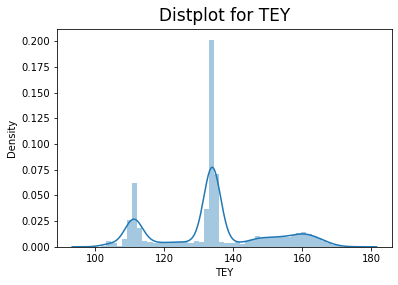

In [14]:
plt.title('Distplot for TEY', fontsize=17, y = 1.01)
sns.distplot(df['TEY'])

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distplot for AT'}, xlabel='AT', ylabel='Density'>

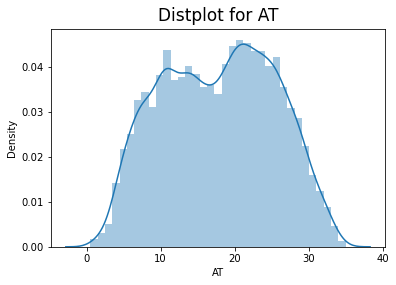

In [15]:
plt.title('Distplot for AT', fontsize=17, y =1.01)
sns.distplot(df['AT'])

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distplot for AP'}, xlabel='AP', ylabel='Density'>

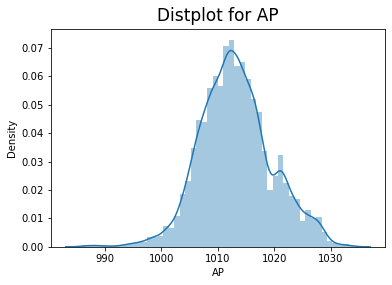

In [16]:
plt.title('Distplot for AP', fontsize=17, y = 1.01)
sns.distplot(df['AP'])

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distplot for AH'}, xlabel='AH', ylabel='Density'>

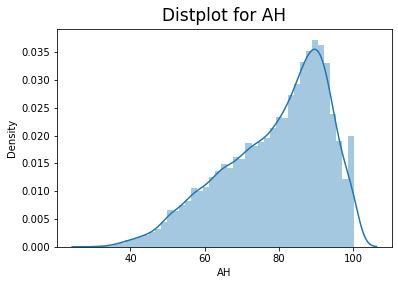

In [17]:
plt.title('Distplot for AH', fontsize=17, y = 1.01)
sns.distplot(df['AH'])

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distplot for AFDP'}, xlabel='AFDP', ylabel='Density'>

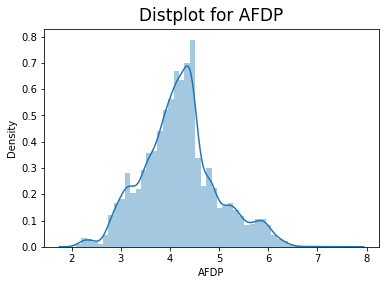

In [18]:
plt.title('Distplot for AFDP', fontsize=17, y = 1.01)
sns.distplot(df['AFDP'])

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distplot for GTEP'}, xlabel='GTEP', ylabel='Density'>

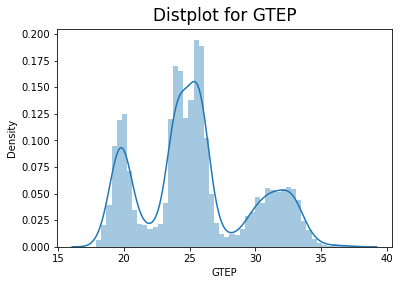

In [19]:
plt.title('Distplot for GTEP', fontsize=17, y = 1.01)
sns.distplot(df['GTEP'])

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distplot for TIT'}, xlabel='TIT', ylabel='Density'>

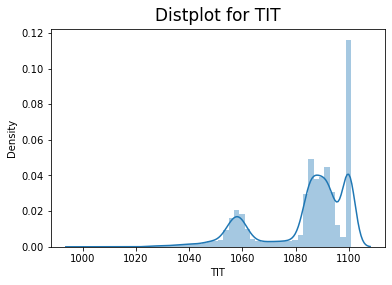

In [20]:
plt.title('Distplot for TIT', fontsize=17, y = 1.01)
sns.distplot(df['TIT'])

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distplot for TAT'}, xlabel='TAT', ylabel='Density'>

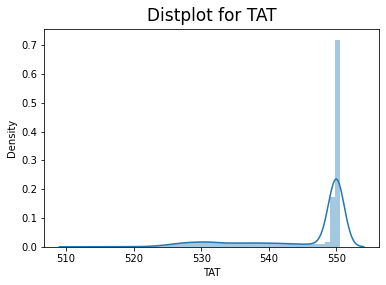

In [21]:
plt.title('Distplot for TAT', fontsize=17, y = 1.01)
sns.distplot(df['TAT'])

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distplot for CDP'}, xlabel='CDP', ylabel='Density'>

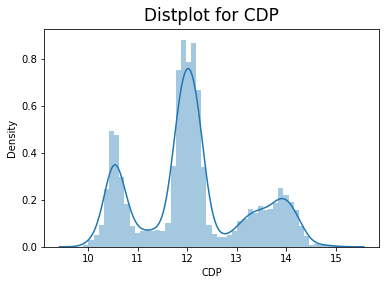

In [22]:
plt.title('Distplot for CDP', fontsize=17, y = 1.01)
sns.distplot(df['CDP'])

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distplot for CO'}, xlabel='CO', ylabel='Density'>

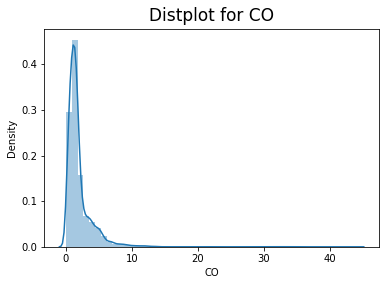

In [23]:
plt.title('Distplot for CO', fontsize=17, y = 1.01)
sns.distplot(df['CO'])

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distplot for NOX'}, xlabel='NOX', ylabel='Density'>

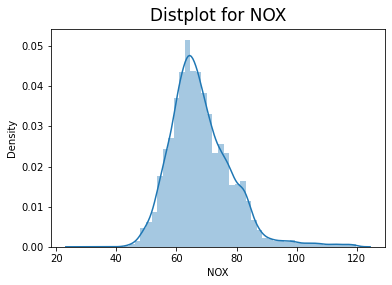

In [24]:
plt.title('Distplot for NOX', fontsize=17, y = 1.01)
sns.distplot(df['NOX'])

- Some of the features are normally distributed.
- The features AH, CO,TIT and TAT exhibit the highest skew coeffcients
- The distribution of CO and TAT and TAT seems to contains many outliers

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\li

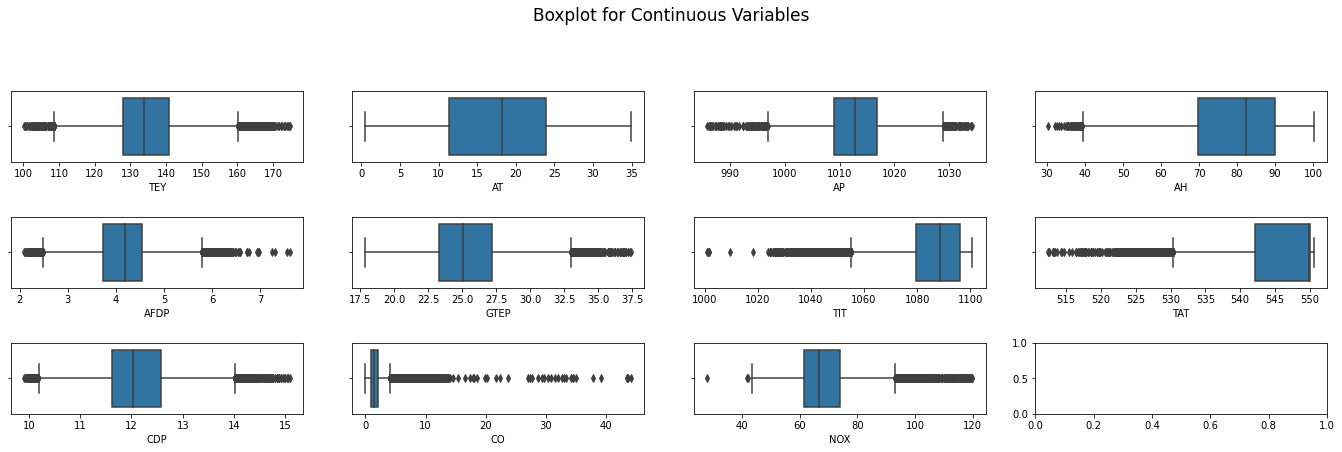

In [25]:
#check for outliers
fig,ax=plt.subplots(3,4, figsize=(19,6), sharex=False, sharey=False)
sns.boxplot(df.TEY, ax=ax[0,0])
sns.boxplot(df.AT, ax=ax[0,1])
sns.boxplot(df.AP, ax=ax[0,2])
sns.boxplot(df.AH, ax=ax[0,3])
sns.boxplot(df.AFDP, ax=ax[1,0])
sns.boxplot(df.GTEP, ax=ax[1,1])
sns.boxplot(df.TIT, ax=ax[1,2])
sns.boxplot(df.TAT, ax=ax[1,3])
sns.boxplot(df.CDP, ax=ax[2,0])
sns.boxplot(df.CO, ax=ax[2,1])
sns.boxplot(df.NOX, ax=ax[2,2])
plt.suptitle("Boxplot for Continuous Variables", fontsize= 17, y = 1.06)
plt.tight_layout(pad=2.0)

- we have a noisy data so we use different transformation

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\li

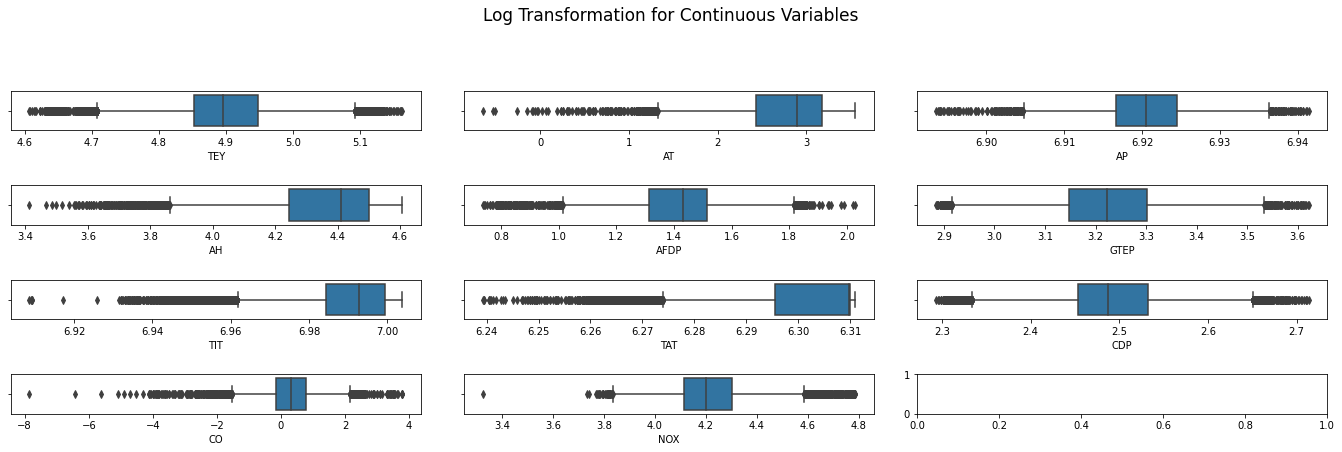

In [26]:
#log transformation
import numpy as np
fig, ax=plt.subplots(4,3, figsize=(19,6), sharex= False, sharey = False)
sns.boxplot(np.log(df.TEY), ax=ax[0,0])
sns.boxplot(np.log(df.AT), ax=ax[0,1])
sns.boxplot(np.log(df.AP), ax=ax[0,2])
sns.boxplot(np.log(df.AH), ax=ax[1,0])
sns.boxplot(np.log(df.AFDP), ax=ax[1,1])
sns.boxplot(np.log(df.GTEP), ax=ax[1,2])
sns.boxplot(np.log(df.TIT), ax=ax[2,0])
sns.boxplot(np.log(df.TAT), ax=ax[2,1])
sns.boxplot(np.log(df.CDP), ax=ax[2,2])
sns.boxplot(np.log(df.CO), ax=ax[3,0])
sns.boxplot(np.log(df.NOX), ax=ax[3,1])
plt.suptitle("Log Transformation for Continuous Variables", fontsize= 17, y = 1.06)
plt.tight_layout(pad=2.0)

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\li

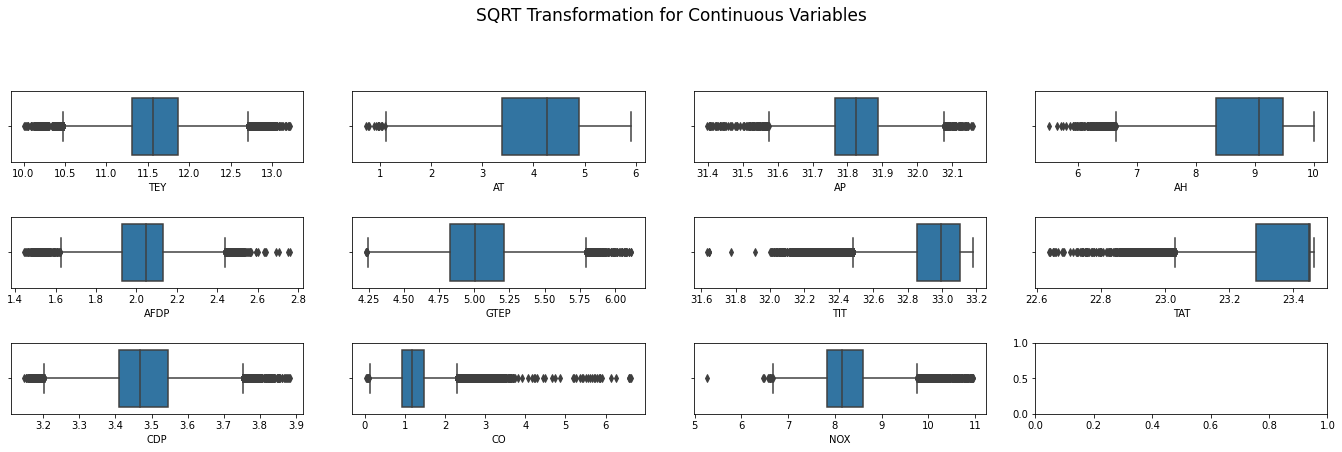

In [27]:
#SQRT transformation
fig, ax=plt.subplots(3,4, figsize=(19,6), sharex= False, sharey = False)
sns.boxplot(np.sqrt(df.TEY), ax=ax[0,0])
sns.boxplot(np.sqrt(df.AT), ax=ax[0,1])
sns.boxplot(np.sqrt(df.AP), ax=ax[0,2])
sns.boxplot(np.sqrt(df.AH), ax=ax[0,3])
sns.boxplot(np.sqrt(df.AFDP), ax=ax[1,0])
sns.boxplot(np.sqrt(df.GTEP), ax=ax[1,1])
sns.boxplot(np.sqrt(df.TIT), ax=ax[1,2])
sns.boxplot(np.sqrt(df.TAT), ax=ax[1,3])
sns.boxplot(np.sqrt(df.CDP), ax=ax[2,0])
sns.boxplot(np.sqrt(df.CO), ax=ax[2,1])
sns.boxplot(np.sqrt(df.NOX), ax=ax[2,2])
plt.suptitle("SQRT Transformation for Continuous Variables", fontsize= 17, y = 1.06)
plt.tight_layout(pad=2.0)

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\li

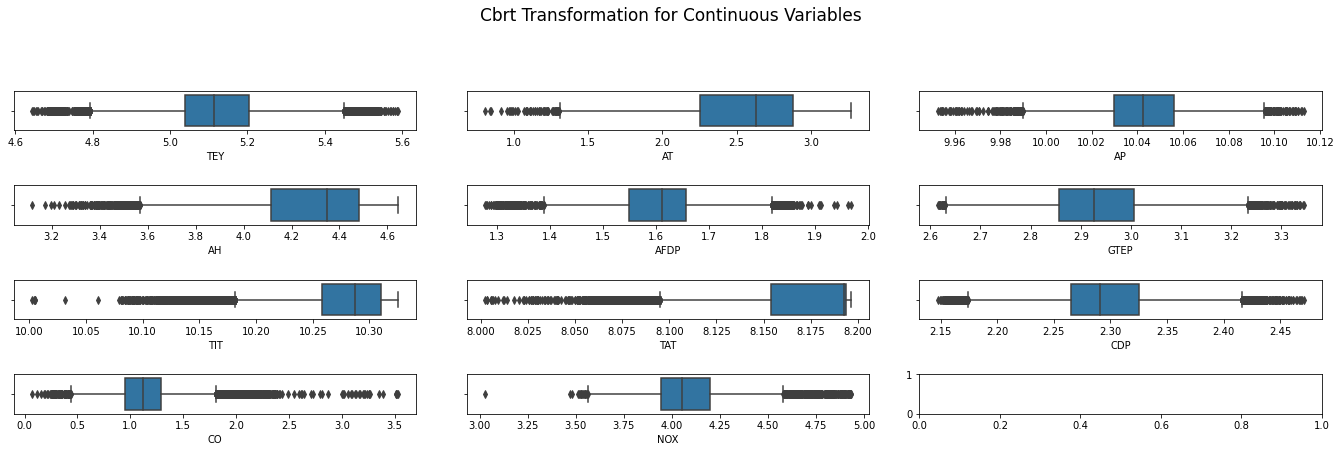

In [28]:
#cbrt transformation
fig, ax=plt.subplots(4,3, figsize=(19,6), sharex= False, sharey = False)
sns.boxplot(np.cbrt(df.TEY), ax=ax[0,0])
sns.boxplot(np.cbrt(df.AT), ax=ax[0,1])
sns.boxplot(np.cbrt(df.AP), ax=ax[0,2])
sns.boxplot(np.cbrt(df.AH), ax=ax[1,0])
sns.boxplot(np.cbrt(df.AFDP), ax=ax[1,1])
sns.boxplot(np.cbrt(df.GTEP), ax=ax[1,2])
sns.boxplot(np.cbrt(df.TIT), ax=ax[2,0])
sns.boxplot(np.cbrt(df.TAT), ax=ax[2,1])
sns.boxplot(np.cbrt(df.CDP), ax=ax[2,2])
sns.boxplot(np.cbrt(df.CO), ax=ax[3,0])
sns.boxplot(np.cbrt(df.NOX), ax=ax[3,1])
plt.suptitle("Cbrt Transformation for Continuous Variables", fontsize= 17, y = 1.06)
plt.tight_layout(pad=2.0)

- None of the transformation are helpfull to treat the outliers

- drawing a pairplot to visually examine the correlation between the features.

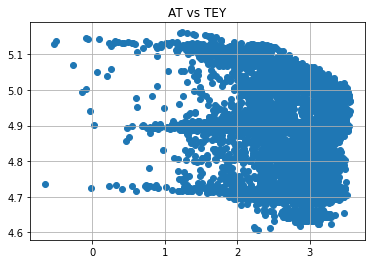

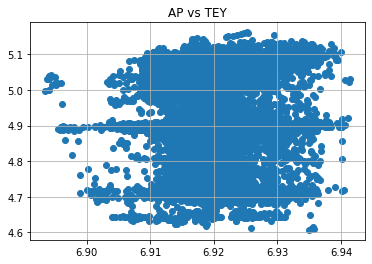

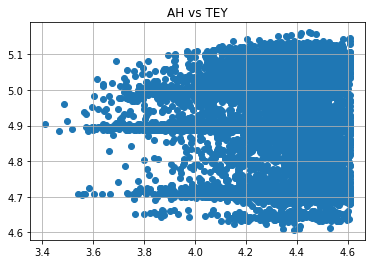

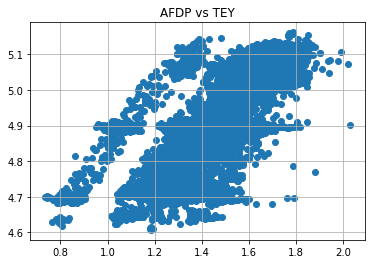

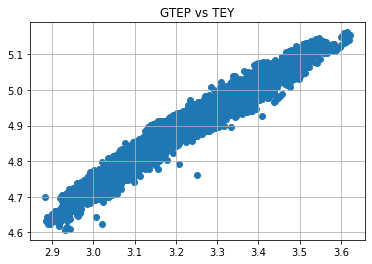

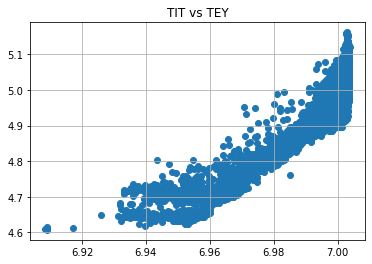

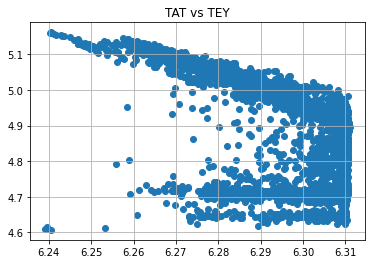

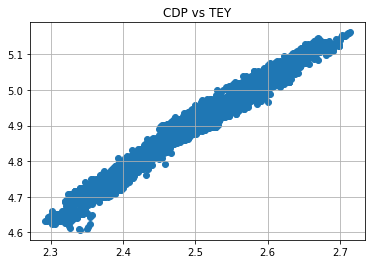

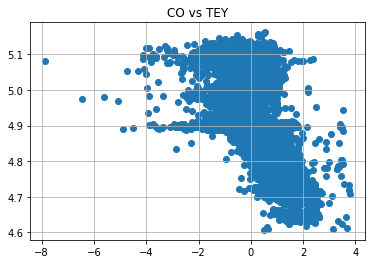

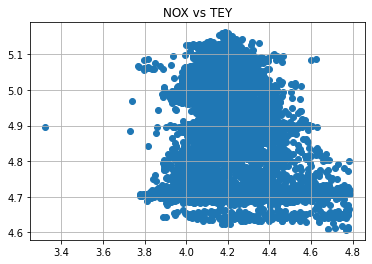

In [29]:
for i in df.columns:
    if i!="TEY": 
        plt.scatter(np.log(df[i]), np.log(df['TEY']))
        plt.title(i+ ' vs TEY')
        plt.grid()
        plt.show()


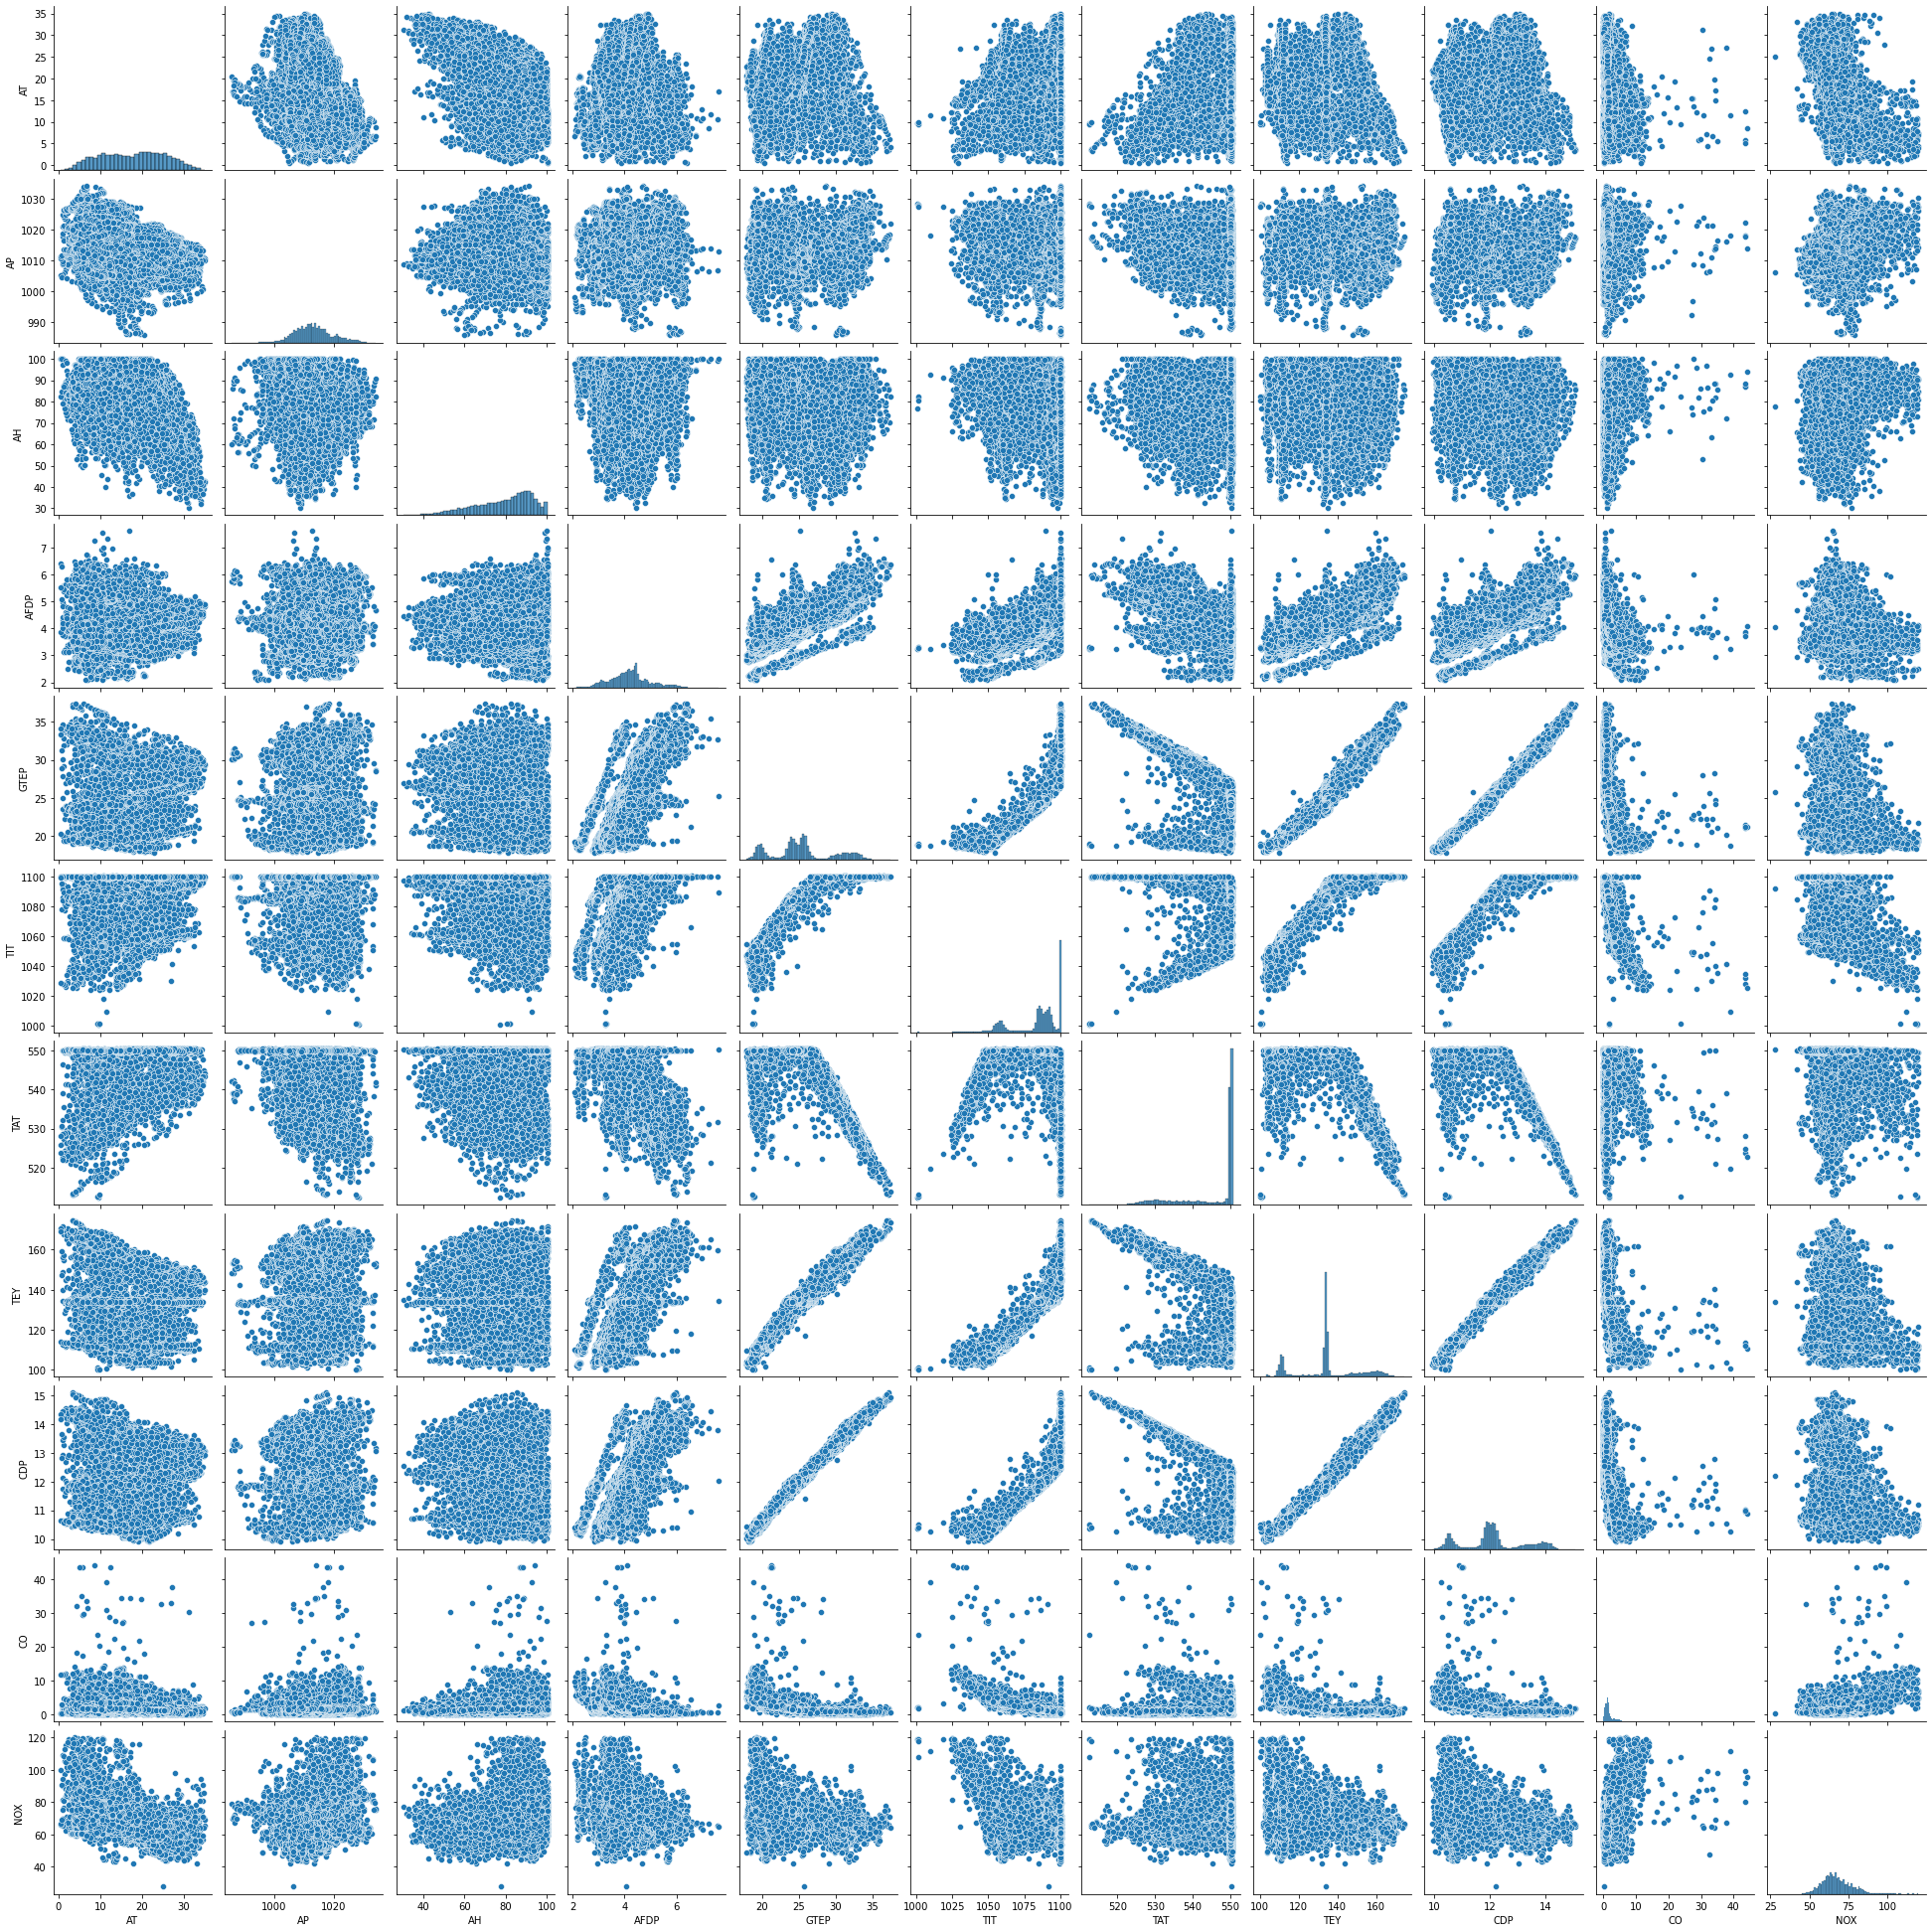

In [30]:
sns.pairplot(df)

In [31]:
corr = pd.DataFrame(data = df.corr().iloc[:,7], index=df.columns)
corr = corr.sort_values(by='TEY', ascending=False)
corr

TEY
TEY   1.000000
CDP   0.988473
GTEP  0.977042
TIT   0.891587
AFDP  0.717995
AP    0.146939
NOX  -0.102631
AH   -0.110272
AT   -0.207495
CO   -0.541751
TAT  -0.720356

<AxesSubplot:title={'center':'Correlation plot between Target variables and independent variables'}, ylabel='TEY'>

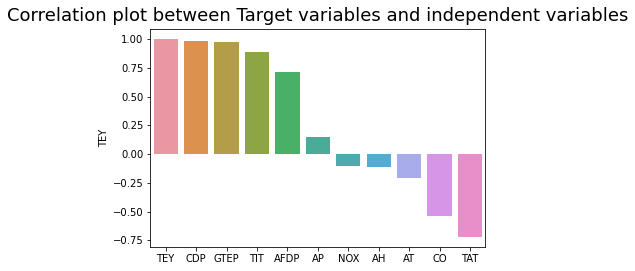

In [32]:
plt.title("Correlation plot between Target variables and independent variables", y=1.01, fontsize=18)
sns.barplot(x = corr.index, y = corr.TEY)

Text(0.5, 1.0, 'Correlation Map of variables')

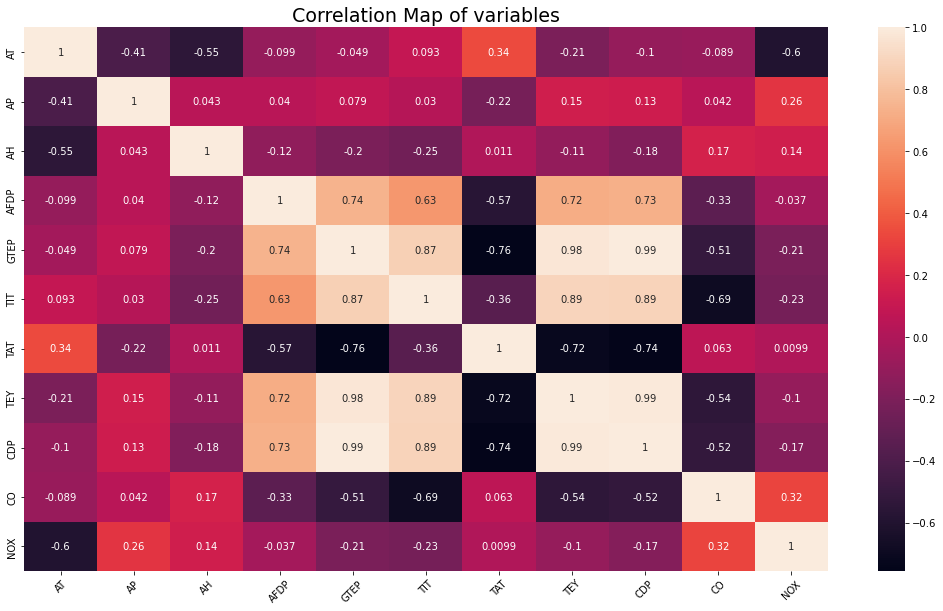

In [33]:
fig= plt.figure(figsize=(18, 10))
sns.heatmap(df.corr(), annot=True);
plt.xticks(rotation=45)
plt.title("Correlation Map of variables", fontsize=19)

In [34]:
import ppscore as pps

In [35]:
score = pps.matrix(df)
score_s = score[score['y']=='TEY']
score_s.sort_values(by='ppscore', ascending=False)

x    y   ppscore            case  is_valid_score               metric  \
84    TEY  TEY  1.000000  predict_itself            True                 None   
95    CDP  TEY  0.872285      regression            True  mean absolute error   
51   GTEP  TEY  0.832336      regression            True  mean absolute error   
62    TIT  TEY  0.766040      regression            True  mean absolute error   
73    TAT  TEY  0.226050      regression            True  mean absolute error   
40   AFDP  TEY  0.152509      regression            True  mean absolute error   
106    CO  TEY  0.055869      regression            True  mean absolute error   
7      AT  TEY  0.000000      regression            True  mean absolute error   
18     AP  TEY  0.000000      regression            True  mean absolute error   
29     AH  TEY  0.000000      regression            True  mean absolute error   
117   NOX  TEY  0.000000      regression            True  mean absolute error   

     baseline_score  model_score                    model  
84         0.000000     1.000000                     None  
95        11.172076     1.426840  DecisionTreeRegressor()  
51        11.172076     1.873154  DecisionTreeRegressor()  
62        11.172076     2.613821  DecisionTreeRegressor()  
73        11.172076     8.646631  DecisionTreeRegressor()  
40        11.172076     9.468234  DecisionTreeRegressor()  
106       11.172076    10.547906  DecisionTreeRegressor()  
7         11.172076    16.007470  DecisionTreeRegressor()  
18        11.172076    12.475617  DecisionTreeRegressor()  
29        11.172076    16.950976  DecisionTreeRegressor()  
117       11.172076    14.537337  DecisionTreeRegressor()

Text(0.5, 1.01, 'PPScore of each feature with Target variable')

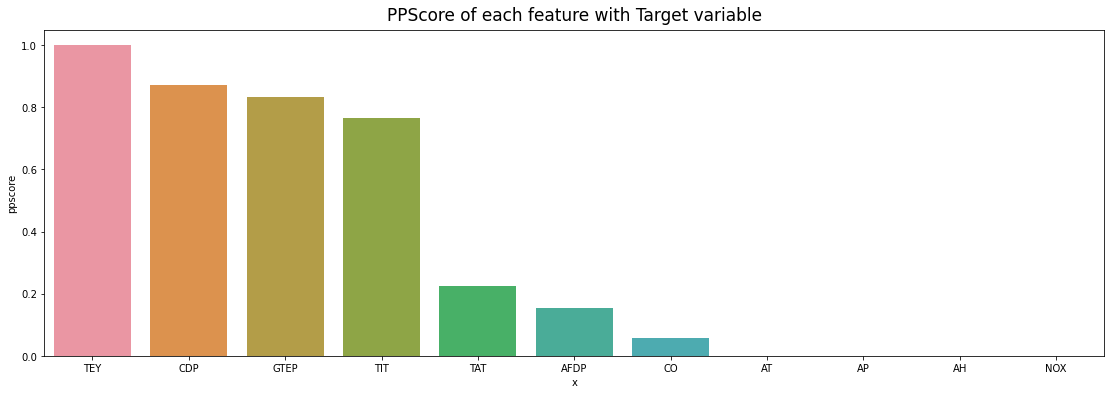

In [36]:
plt.rcParams['figure.figsize']=(19,6)
sns.barplot(x='x', y='ppscore', data=score_s.sort_values(by='ppscore', ascending=False))
plt.title("PPScore of each feature with Target variable", fontsize=17, y=1.01)

- From the above correlation matrix as well as ppscore we can clearly see that TEY is highly dependant on CDP, GTEP, TIT
- We can drop AT, AP, AH, NOX as they have very less impact on dependant variables

### Checking for outliers

In [37]:
#check for outliers
from sklearn.ensemble import IsolationForest
data1=df.copy()

#training the model
clf = IsolationForest(random_state=10, contamination=.001)
clf.fit(data1)
data1['anamoly'] = clf.predict(data1.iloc[:,0:11])
outliers = data1[data1['anamoly']==-1]

In [38]:
outliers

AT       AP      AH    AFDP    GTEP     TIT     TAT     TEY  \
261     5.66020  1018.30  86.968  3.8404  21.079  1028.5  523.86  112.02   
553     3.55320  1027.30  90.871  4.2162  21.464  1041.2  531.68  117.76   
763     1.81300  1007.20  74.980  3.6967  19.958  1026.4  528.18  111.72   
764     1.49880  1006.30  76.734  3.7063  20.041  1027.6  528.79  112.28   
765     0.97877  1005.70  78.978  3.7379  20.084  1027.9  528.52  112.71   
993     4.36570  1021.60  85.528  3.9574  20.263  1025.6  525.72  111.35   
6896   17.13200  1010.80  80.503  2.2148  18.484  1034.1  539.98  102.07   
7019    7.02760   997.23  97.761  2.0992  19.227  1037.2  538.53  109.63   
7470    7.04730  1019.60  96.885  2.4558  19.501  1032.0  532.32  109.21   
9920   15.17900  1017.60  71.630  2.7816  18.435  1027.8  533.45  103.64   
13820  14.18300  1023.10  78.110  3.1557  18.869  1025.0  530.16  103.80   
13921  11.58500  1018.20  92.751  3.2518  18.784  1009.5  519.71  100.83   
14100   9.40970  1027.90  82.224  3.3003  18.987  1001.4  512.60  100.32   
14278   9.90780  1026.10  65.923  3.3126  19.366  1024.5  527.21  108.08   
14317   3.93850  1021.30  90.536  3.4765  20.031  1026.6  526.30  111.70   
14320   3.49070  1020.80  91.519  3.5309  20.098  1025.8  525.35  111.91   

          CDP       CO      NOX  anamoly  
261    10.963  43.4280   99.237       -1  
553    10.984   8.8254  106.840       -1  
763    10.553  12.0900  114.940       -1  
764    10.585  11.6520  112.830       -1  
765    10.628  11.6910  108.880       -1  
993    10.652  12.7860  112.270       -1  
6896   10.182  11.5150  110.760       -1  
7019   10.338  11.0440  105.060       -1  
7470   10.567  11.3740  112.230       -1  
9920   10.143  12.1440  113.800       -1  
13820  10.340  13.3130  116.340       -1  
13921  10.253  39.0500  111.780       -1  
14100  10.495  23.6290  107.890       -1  
14278  10.506  20.2710  105.660       -1  
14317  10.683  14.0350  114.700       -1  
14320  10.761  11.9210  113.900       -1

In [39]:
df.shape

(15039, 11)

In [40]:
#drop the outliers
df = df.drop(outliers.index)
df.shape

(15023, 11)

In [41]:
#reset index after dropping outliers
df = df.reset_index()
df = df.drop('index', axis = 1)
df

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0      6.8594  1007.9  96.799  3.5000  19.663  1059.2  550.00  114.70  10.605   
1      6.7850  1008.4  97.118  3.4998  19.728  1059.3  550.00  114.72  10.598   
2      6.8977  1008.8  95.939  3.4824  19.779  1059.4  549.87  114.71  10.601   
3      7.0569  1009.2  95.249  3.4805  19.792  1059.6  549.99  114.72  10.606   
4      7.3978  1009.7  95.150  3.4976  19.765  1059.7  549.98  114.72  10.612   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
15018  9.0301  1005.6  98.460  3.5421  19.164  1049.7  546.21  111.61  10.400   
15019  7.8879  1005.9  99.093  3.5059  19.414  1046.3  543.22  111.78  10.433   
15020  7.2647  1006.3  99.496  3.4770  19.530  1037.7  537.32  110.19  10.483   
15021  7.0060  1006.8  99.008  3.4486  19.377  1043.2  541.24  110.74  10.533   
15022  6.9279  1007.2  97.533  3.4275  19.306  1049.9  545.85  111.58  10.583   

           CO     NOX  
0      3.1547  82.722  
1      3.2363  82.776  
2      3.2012  82.468  
3      3.1923  82.670  
4      3.2484  82.311  
...       ...     ...  
15018  4.5186  79.559  
15019  4.8470  79.917  
15020  7.9632  90.912  
15021  6.2494  93.227  
15022  4.9816  92.498  

[15023 rows x 11 columns]

In [42]:
df = df.drop(['AT', 'AT','AH', 'NOX'], axis=1)

In [43]:
df.shape

(15023, 8)

#### converting independant features into normalised and standardized data

In [44]:
model_data = df[['CDP', 'GTEP','TIT', 'TAT', 'AFDP', 'CO', "TEY"]]
model_data.head()

CDP    GTEP     TIT     TAT    AFDP      CO     TEY
0  10.605  19.663  1059.2  550.00  3.5000  3.1547  114.70
1  10.598  19.728  1059.3  550.00  3.4998  3.2363  114.72
2  10.601  19.779  1059.4  549.87  3.4824  3.2012  114.71
3  10.606  19.792  1059.6  549.99  3.4805  3.1923  114.72
4  10.612  19.765  1059.7  549.98  3.4976  3.2484  114.72

In [45]:
#Standardize & Normalize the data
norm = MinMaxScaler()
std = StandardScaler()

df_norm = pd.DataFrame(norm.fit_transform(df), columns=df.columns)            #data between -3 to +3
df_std = pd.DataFrame(std.fit_transform(df), columns=df.columns)            #data between  -1 to 1

In [46]:
print('Mean' '\n',np.round(df_std.mean(),1),'\n' 'Standard Devaition','\n',np.round(df_std.std()),1)

Mean
 AP     -0.0
AFDP    0.0
GTEP   -0.0
TIT     0.0
TAT    -0.0
TEY    -0.0
CDP    -0.0
CO      0.0
dtype: float64 
Standard Devaition 
 AP      1.0
AFDP    1.0
GTEP    1.0
TIT     1.0
TAT     1.0
TEY     1.0
CDP     1.0
CO      1.0
dtype: float64 1


### Splitting data into target variable and independant variable

In [47]:
x = df_std.drop('TEY', axis=1)
y = df_std[['TEY']]

In [48]:
#splitting data into train and test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=3)

### Hyperparameter Tuning

#### Hyperparameter tuning for Optimal Learning rate, Number of Layers and Neurons

In [49]:
def build_model(hp):
    model =Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=100,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [50]:
tuner = RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=5,  executions_per_trial=3,directory='project',project_name='Gas Turbine')


INFO:tensorflow:Reloading Oracle from existing project project\Gas Turbine\oracle.json
INFO:tensorflow:Reloading Tuner from project\Gas Turbine\tuner0.json


In [51]:
tuner.search_space_summary()

Search space summary
Default search space size: 17
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_6 (Int)
{'default': None, 'co

In [52]:
tuner.search(x_train, y_train,epochs=100,validation_data=(x_test, y_test))


INFO:tensorflow:Oracle triggered exit


In [53]:
tuner.search_space_summary()

Search space summary
Default search space size: 17
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_6 (Int)
{'default': None, 'co

#### Hyperparameter tuning for Optimal Batch_size, Number of Epochs

In [54]:
def create_model():
    model1 = Sequential()
    model1.add(Dense(32,input_dim=7,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(units=1,activation="linear"))
    
    adam=Adam(learning_rate=0.001)
    model1.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model1

In [55]:
model1 =KerasRegressor(build_fn=create_model,verbose=0)
batch_size=[10,20,40,50]
epochs=[10,50,100,200]
param_grid=dict(batch_size=batch_size,epochs=epochs)
grid = GridSearchCV(estimator=model1,param_grid=param_grid,cv=KFold(),verbose=10)

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_11044/2023109169.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model1 =KerasRegressor(build_fn=create_model,verbose=0)


In [56]:
grid_result = grid.fit(x_test,y_test)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START batch_size=10, epochs=10...................................
[CV 1/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.086 total time=   6.3s
[CV 2/5; 1/16] START batch_size=10, epochs=10...................................
[CV 2/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.080 total time=   6.2s
[CV 3/5; 1/16] START batch_size=10, epochs=10...................................
[CV 3/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.067 total time=   6.0s
[CV 4/5; 1/16] START batch_size=10, epochs=10...................................
[CV 4/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.075 total time=   5.7s
[CV 5/5; 1/16] START batch_size=10, epochs=10...................................
[CV 5/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.075 total time=   5.6s
[CV 1/5; 2/16] START batch_size=10, epochs=50...................................
[CV 1/5; 2/16] END ...batch_size=10, epochs=50;,

In [57]:
print('Best {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best -0.04843349307775498, using {'batch_size': 40, 'epochs': 200}
-0.07638979703187943,0.006365930193536551 with {'batch_size': 10, 'epochs': 10}
-0.056305442750453946,0.00611881486277594 with {'batch_size': 10, 'epochs': 50}
-0.05438391864299774,0.003668565989367783 with {'batch_size': 10, 'epochs': 100}
-0.059579963237047194,0.006794776124703116 with {'batch_size': 10, 'epochs': 200}
-0.07060953378677368,0.005690064563185051 with {'batch_size': 20, 'epochs': 10}
-0.0572953462600708,0.006344451073567101 with {'batch_size': 20, 'epochs': 50}
-0.053993909060955046,0.0027542113820505274 with {'batch_size': 20, 'epochs': 100}
-0.049257367849349976,0.003015457645439144 with {'batch_size': 20, 'epochs': 200}
-0.07745715379714965,0.006502036709154762 with {'batch_size': 40, 'epochs': 10}
-0.06614589840173721,0.005929500734838771 with {'batch_size': 40, 'epochs': 50}
-0.054510883241891864,0.007084035583247324 with {'batch_size': 40, 'epochs': 100}
-0.04843349307775498,0.003948254197091735 wi

### Hyperparameter tuning for Optimal Dropout rate

In [58]:
def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(32,input_dim=7,activation='relu'))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(units=1,activation="linear"))
    
    adam=Adam(lr=0.001)
    model2.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model2

In [59]:
model2=KerasRegressor(build_fn=create_model,batch_size=40,epochs=200,verbose=0)
dropout_rate=[0.0,0.1,0.2,0.3,0.4,0.5]
param_grid=dict(dropout_rate=dropout_rate)
grid2 = GridSearchCV(estimator=model2,param_grid=param_grid,cv=KFold(),verbose=10)


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_11044/4290832032.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model2=KerasRegressor(build_fn=create_model,batch_size=40,epochs=200,verbose=0)


In [60]:
grid_result2 = grid2.fit(x_test,y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START dropout_rate=0.0............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 1/6] END ............dropout_rate=0.0;, score=-0.053 total time=  38.5s
[CV 2/5; 1/6] START dropout_rate=0.0............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 1/6] END ............dropout_rate=0.0;, score=-0.054 total time=  36.9s
[CV 3/5; 1/6] START dropout_rate=0.0............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 1/6] END ............dropout_rate=0.0;, score=-0.048 total time=  37.1s
[CV 4/5; 1/6] START dropout_rate=0.0............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 1/6] END ............dropout_rate=0.0;, score=-0.048 total time=  34.9s
[CV 5/5; 1/6] START dropout_rate=0.0............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 1/6] END ............dropout_rate=0.0;, score=-0.058 total time=  34.0s
[CV 1/5; 2/6] START dropout_rate=0.1............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 2/6] END ............dropout_rate=0.1;, score=-0.050 total time=  34.4s
[CV 2/5; 2/6] START dropout_rate=0.1............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 2/6] END ............dropout_rate=0.1;, score=-0.051 total time=  32.3s
[CV 3/5; 2/6] START dropout_rate=0.1............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 2/6] END ............dropout_rate=0.1;, score=-0.049 total time=  30.0s
[CV 4/5; 2/6] START dropout_rate=0.1............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 2/6] END ............dropout_rate=0.1;, score=-0.049 total time=  29.0s
[CV 5/5; 2/6] START dropout_rate=0.1............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 2/6] END ............dropout_rate=0.1;, score=-0.048 total time=  29.9s
[CV 1/5; 3/6] START dropout_rate=0.2............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 3/6] END ............dropout_rate=0.2;, score=-0.052 total time=  28.7s
[CV 2/5; 3/6] START dropout_rate=0.2............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 3/6] END ............dropout_rate=0.2;, score=-0.047 total time=  29.8s
[CV 3/5; 3/6] START dropout_rate=0.2............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 3/6] END ............dropout_rate=0.2;, score=-0.047 total time=  28.5s
[CV 4/5; 3/6] START dropout_rate=0.2............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 3/6] END ............dropout_rate=0.2;, score=-0.047 total time=  38.3s
[CV 5/5; 3/6] START dropout_rate=0.2............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 3/6] END ............dropout_rate=0.2;, score=-0.058 total time=  37.8s
[CV 1/5; 4/6] START dropout_rate=0.3............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 4/6] END ............dropout_rate=0.3;, score=-0.054 total time=  36.6s
[CV 2/5; 4/6] START dropout_rate=0.3............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 4/6] END ............dropout_rate=0.3;, score=-0.064 total time=  35.5s
[CV 3/5; 4/6] START dropout_rate=0.3............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 4/6] END ............dropout_rate=0.3;, score=-0.048 total time=  37.0s
[CV 4/5; 4/6] START dropout_rate=0.3............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 4/6] END ............dropout_rate=0.3;, score=-0.054 total time=  35.8s
[CV 5/5; 4/6] START dropout_rate=0.3............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 4/6] END ............dropout_rate=0.3;, score=-0.051 total time=  32.4s
[CV 1/5; 5/6] START dropout_rate=0.4............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 5/6] END ............dropout_rate=0.4;, score=-0.052 total time=  31.7s
[CV 2/5; 5/6] START dropout_rate=0.4............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 5/6] END ............dropout_rate=0.4;, score=-0.050 total time=  31.2s
[CV 3/5; 5/6] START dropout_rate=0.4............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 5/6] END ............dropout_rate=0.4;, score=-0.046 total time=  30.7s
[CV 4/5; 5/6] START dropout_rate=0.4............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 5/6] END ............dropout_rate=0.4;, score=-0.051 total time=  30.9s
[CV 5/5; 5/6] START dropout_rate=0.4............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 5/6] END ............dropout_rate=0.4;, score=-0.047 total time=  30.1s
[CV 1/5; 6/6] START dropout_rate=0.5............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 6/6] END ............dropout_rate=0.5;, score=-0.049 total time=  29.7s
[CV 2/5; 6/6] START dropout_rate=0.5............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 6/6] END ............dropout_rate=0.5;, score=-0.050 total time=  29.6s
[CV 3/5; 6/6] START dropout_rate=0.5............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 6/6] END ............dropout_rate=0.5;, score=-0.049 total time=  28.8s
[CV 4/5; 6/6] START dropout_rate=0.5............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 6/6] END ............dropout_rate=0.5;, score=-0.048 total time=  29.4s
[CV 5/5; 6/6] START dropout_rate=0.5............................................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 6/6] END ............dropout_rate=0.5;, score=-0.048 total time=  28.7s


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [61]:
print('Best {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means = grid_result2.cv_results_["mean_test_score"]
stds = grid_result2.cv_results_["std_test_score"]
params = grid_result2.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best -0.048719564080238344, using {'dropout_rate': 0.5}
-0.05225094705820084,0.003754000916134169 with {'dropout_rate': 0.0}
-0.049460412561893465,0.0008643478359789639 with {'dropout_rate': 0.1}
-0.05019068717956543,0.0043057177194901625 with {'dropout_rate': 0.2}
-0.054019595682621005,0.005367271470168343 with {'dropout_rate': 0.3}
-0.04903920963406563,0.0022180042846057886 with {'dropout_rate': 0.4}
-0.048719564080238344,0.0005600289440889264 with {'dropout_rate': 0.5}


### Hyperparameter Tuning: Optimal Activation Function and Kernel Initializer

In [62]:
def create_model(activation_function,init):
    model3 = Sequential()
    model3.add(Dense(32,input_dim=7,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(units=1,activation="linear"))
    
    adam=Adam(lr=0.001)
    model3.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model3

In [63]:
model3=KerasRegressor(build_fn=create_model,batch_size=40,epochs=200,verbose=0)
activation_function=['softmax','tanh','relu']
init=['normal','uniform','zero']
param_grid=dict(activation_function=activation_function,init=init)
grid3 = GridSearchCV(estimator=model3,param_grid=param_grid,cv=KFold(),verbose=10)


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_11044/113265078.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model3=KerasRegressor(build_fn=create_model,batch_size=40,epochs=200,verbose=0)


In [73]:
grid_result3 = grid3.fit(x_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START activation_function=softmax, init=normal....................
[CV 1/5; 1/9] END activation_function=softmax, init=normal;, score=nan total time=   0.1s
[CV 2/5; 1/9] START activation_function=softmax, init=normal....................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 2/5; 1/9] END activation_function=softmax, init=normal;, score=nan total time=   0.1s
[CV 3/5; 1/9] START activation_function=softmax, init=normal....................
[CV 3/5; 1/9] END activation_function=softmax, init=normal;, score=nan total time=   0.1s
[CV 4/5; 1/9] START activation_function=softmax, init=normal....................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 4/5; 1/9] END activation_function=softmax, init=normal;, score=nan total time=   0.1s
[CV 5/5; 1/9] START activation_function=softmax, init=normal....................
[CV 5/5; 1/9] END activation_function=softmax, init=normal;, score=nan total time=   0.1s
[CV 1/5; 2/9] START activation_function=softmax, init=uniform...................


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_filexm1qv8th.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "C:\User

[CV 1/5; 2/9] END activation_function=softmax, init=uniform;, score=nan total time=   0.1s
[CV 2/5; 2/9] START activation_function=softmax, init=uniform...................
[CV 2/5; 2/9] END activation_function=softmax, init=uniform;, score=nan total time=   0.1s
[CV 3/5; 2/9] START activation_function=softmax, init=uniform...................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 3/5; 2/9] END activation_function=softmax, init=uniform;, score=nan total time=   0.1s
[CV 4/5; 2/9] START activation_function=softmax, init=uniform...................
[CV 4/5; 2/9] END activation_function=softmax, init=uniform;, score=nan total time=   0.1s
[CV 5/5; 2/9] START activation_function=softmax, init=uniform...................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 5/5; 2/9] END activation_function=softmax, init=uniform;, score=nan total time=   0.1s
[CV 1/5; 3/9] START activation_function=softmax, init=zero......................
[CV 1/5; 3/9] END activation_function=softmax, init=zero;, score=nan total time=   0.1s
[CV 2/5; 3/9] START activation_function=softmax, init=zero......................


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_filexm1qv8th.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "C:\User

[CV 2/5; 3/9] END activation_function=softmax, init=zero;, score=nan total time=   0.1s
[CV 3/5; 3/9] START activation_function=softmax, init=zero......................
[CV 3/5; 3/9] END activation_function=softmax, init=zero;, score=nan total time=   0.1s
[CV 4/5; 3/9] START activation_function=softmax, init=zero......................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 4/5; 3/9] END activation_function=softmax, init=zero;, score=nan total time=   0.1s
[CV 5/5; 3/9] START activation_function=softmax, init=zero......................
[CV 5/5; 3/9] END activation_function=softmax, init=zero;, score=nan total time=   0.1s
[CV 1/5; 4/9] START activation_function=tanh, init=normal.......................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 1/5; 4/9] END activation_function=tanh, init=normal;, score=nan total time=   0.1s
[CV 2/5; 4/9] START activation_function=tanh, init=normal.......................
[CV 2/5; 4/9] END activation_function=tanh, init=normal;, score=nan total time=   0.1s
[CV 3/5; 4/9] START activation_function=tanh, init=normal.......................


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_filexm1qv8th.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "C:\User

[CV 3/5; 4/9] END activation_function=tanh, init=normal;, score=nan total time=   0.1s
[CV 4/5; 4/9] START activation_function=tanh, init=normal.......................
[CV 4/5; 4/9] END activation_function=tanh, init=normal;, score=nan total time=   0.1s
[CV 5/5; 4/9] START activation_function=tanh, init=normal.......................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 5/5; 4/9] END activation_function=tanh, init=normal;, score=nan total time=   0.1s
[CV 1/5; 5/9] START activation_function=tanh, init=uniform......................
[CV 1/5; 5/9] END activation_function=tanh, init=uniform;, score=nan total time=   0.1s
[CV 2/5; 5/9] START activation_function=tanh, init=uniform......................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 2/5; 5/9] END activation_function=tanh, init=uniform;, score=nan total time=   0.1s
[CV 3/5; 5/9] START activation_function=tanh, init=uniform......................
[CV 3/5; 5/9] END activation_function=tanh, init=uniform;, score=nan total time=   0.1s
[CV 4/5; 5/9] START activation_function=tanh, init=uniform......................


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_filexm1qv8th.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "C:\User

[CV 4/5; 5/9] END activation_function=tanh, init=uniform;, score=nan total time=   0.1s
[CV 5/5; 5/9] START activation_function=tanh, init=uniform......................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 5/5; 5/9] END activation_function=tanh, init=uniform;, score=nan total time=   0.1s
[CV 1/5; 6/9] START activation_function=tanh, init=zero.........................


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_filexm1qv8th.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "C:\User

[CV 1/5; 6/9] END activation_function=tanh, init=zero;, score=nan total time=   0.1s
[CV 2/5; 6/9] START activation_function=tanh, init=zero.........................
[CV 2/5; 6/9] END activation_function=tanh, init=zero;, score=nan total time=   0.1s
[CV 3/5; 6/9] START activation_function=tanh, init=zero.........................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 3/5; 6/9] END activation_function=tanh, init=zero;, score=nan total time=   0.5s
[CV 4/5; 6/9] START activation_function=tanh, init=zero.........................
[CV 4/5; 6/9] END activation_function=tanh, init=zero;, score=nan total time=   0.1s
[CV 5/5; 6/9] START activation_function=tanh, init=zero.........................


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_filexm1qv8th.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "C:\User

[CV 5/5; 6/9] END activation_function=tanh, init=zero;, score=nan total time=   0.1s
[CV 1/5; 7/9] START activation_function=relu, init=normal.......................
[CV 1/5; 7/9] END activation_function=relu, init=normal;, score=nan total time=   0.1s
[CV 2/5; 7/9] START activation_function=relu, init=normal.......................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 2/5; 7/9] END activation_function=relu, init=normal;, score=nan total time=   0.1s
[CV 3/5; 7/9] START activation_function=relu, init=normal.......................
[CV 3/5; 7/9] END activation_function=relu, init=normal;, score=nan total time=   0.1s
[CV 4/5; 7/9] START activation_function=relu, init=normal.......................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 4/5; 7/9] END activation_function=relu, init=normal;, score=nan total time=   0.1s
[CV 5/5; 7/9] START activation_function=relu, init=normal.......................
[CV 5/5; 7/9] END activation_function=relu, init=normal;, score=nan total time=   0.1s
[CV 1/5; 8/9] START activation_function=relu, init=uniform......................


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_filexm1qv8th.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "C:\User

[CV 1/5; 8/9] END activation_function=relu, init=uniform;, score=nan total time=   0.1s
[CV 2/5; 8/9] START activation_function=relu, init=uniform......................
[CV 2/5; 8/9] END activation_function=relu, init=uniform;, score=nan total time=   0.1s
[CV 3/5; 8/9] START activation_function=relu, init=uniform......................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 3/5; 8/9] END activation_function=relu, init=uniform;, score=nan total time=   0.1s
[CV 4/5; 8/9] START activation_function=relu, init=uniform......................


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_filexm1qv8th.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "C:\User

[CV 4/5; 8/9] END activation_function=relu, init=uniform;, score=nan total time=   0.1s
[CV 5/5; 8/9] START activation_function=relu, init=uniform......................
[CV 5/5; 8/9] END activation_function=relu, init=uniform;, score=nan total time=   0.1s
[CV 1/5; 9/9] START activation_function=relu, init=zero.........................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 1/5; 9/9] END activation_function=relu, init=zero;, score=nan total time=   0.1s
[CV 2/5; 9/9] START activation_function=relu, init=zero.........................
[CV 2/5; 9/9] END activation_function=relu, init=zero;, score=nan total time=   0.1s
[CV 3/5; 9/9] START activation_function=relu, init=zero.........................


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_filexm1qv8th.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "C:\User

[CV 3/5; 9/9] END activation_function=relu, init=zero;, score=nan total time=   0.1s
[CV 4/5; 9/9] START activation_function=relu, init=zero.........................
[CV 4/5; 9/9] END activation_function=relu, init=zero;, score=nan total time=   0.1s
[CV 5/5; 9/9] START activation_function=relu, init=zero.........................


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Lenovo\AppData\Local\Temp\__autograph_generated_file

[CV 5/5; 9/9] END activation_function=relu, init=zero;, score=nan total time=   0.1s


ValueError: in user code:

    File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Lenovo\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_221" is incompatible with the layer: expected shape=(None, 7), found shape=(None, 6)


In [81]:
print('Best {}, using {}'.format(grid_result3.best_score_,grid_result3.best_params_))
means = grid_result3.cv_results_["mean_test_score"]
stds = grid_result3.cv_results_["std_test_score"]
params = grid_result3.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best nan, using {'activation_function': 'softmax', 'init': 'normal'}
-0.469010466337204,0.21727637707177908 with {'activation_function': 'softmax', 'init': 'normal'}
-0.515504801273346,0.16658187426740872 with {'activation_function': 'softmax', 'init': 'uniform'}
-0.4372886598110199,0.19112949423830494 with {'activation_function': 'softmax', 'init': 'zero'}
-0.7112341225147247,0.15982028928457886 with {'activation_function': 'tanh', 'init': 'normal'}
-0.5772898852825165,0.15133972267956675 with {'activation_function': 'tanh', 'init': 'uniform'}
-0.40804316103458405,0.18400299939459383 with {'activation_function': 'tanh', 'init': 'zero'}
-0.6659607201814651,0.22592191734392347 with {'activation_function': 'relu', 'init': 'normal'}
-0.5248102247714996,0.1261520828250977 with {'activation_function': 'relu', 'init': 'uniform'}
-0.4987072885036469,0.19703540071077785 with {'activation_function': 'relu', 'init': 'zero'}


###  Model Building Neural Networks

#### Standardizing only predictor variable - after train test split

In [74]:
model_data

CDP    GTEP     TIT     TAT    AFDP      CO     TEY
0      10.605  19.663  1059.2  550.00  3.5000  3.1547  114.70
1      10.598  19.728  1059.3  550.00  3.4998  3.2363  114.72
2      10.601  19.779  1059.4  549.87  3.4824  3.2012  114.71
3      10.606  19.792  1059.6  549.99  3.4805  3.1923  114.72
4      10.612  19.765  1059.7  549.98  3.4976  3.2484  114.72
...       ...     ...     ...     ...     ...     ...     ...
15018  10.400  19.164  1049.7  546.21  3.5421  4.5186  111.61
15019  10.433  19.414  1046.3  543.22  3.5059  4.8470  111.78
15020  10.483  19.530  1037.7  537.32  3.4770  7.9632  110.19
15021  10.533  19.377  1043.2  541.24  3.4486  6.2494  110.74
15022  10.583  19.306  1049.9  545.85  3.4275  4.9816  111.58

[15023 rows x 7 columns]

In [75]:
#assigning predictor variables to x and response variable to y
x = model_data.drop('TEY', axis=1)
y = model_data[["TEY"]]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=42)

scaler_train = StandardScaler()
scaler_test = StandardScaler()

x_train_scaled = scaler_train.fit_transform(x_train) # scaling train data -- predictor
x_test_scaled  = scaler_test.fit_transform(x_test) # scaling test data -- predictor

print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

#for removing heading from y_test
#y_test = y_test.values

(12018, 6)
(3005, 6)
(12018, 1)
(3005, 1)


In [76]:
# since we have continuous ouput, AF is not required in the o/p layer
model = Sequential()
model.add( Dense( units = 50 , activation = 'relu' , kernel_initializer = 'normal', input_dim = 6)) # input layer
model.add( Dense( units = 20 , activation = 'tanh' , kernel_initializer = 'normal' )) # hidden layer
model.add( Dense( units = 1  , kernel_initializer = 'normal' )) # o/p layer

model.compile(optimizer= "adam", loss="mse", metrics= ["mae", "mse"])
model.fit(x_train_scaled, y_train , batch_size=50, validation_split=0.3, epochs=100,  verbose=1)

Epoch 1/100
169/169 [==============================] - 1s 2ms/step - loss: 17540.6484 - mae: 131.4929 - mse: 17540.6484 - val_loss: 16657.8555 - val_mae: 128.0843 - val_mse: 16657.8574
Epoch 2/100
169/169 [==============================] - 0s 2ms/step - loss: 16152.9150 - mae: 126.1138 - mse: 16152.9150 - val_loss: 15601.8525 - val_mae: 123.8927 - val_mse: 15601.8525
Epoch 3/100
169/169 [==============================] - 0s 2ms/step - loss: 15178.0195 - mae: 122.1859 - mse: 15178.0195 - val_loss: 14685.8125 - val_mae: 120.1389 - val_mse: 14685.8125
Epoch 4/100
169/169 [==============================] - 0s 2ms/step - loss: 14296.3311 - mae: 118.5210 - mse: 14296.3311 - val_loss: 13836.4160 - val_mae: 116.5502 - val_mse: 13836.4160
Epoch 5/100
169/169 [==============================] - 0s 2ms/step - loss: 13471.1680 - mae: 114.9881 - mse: 13471.1680 - val_loss: 13036.1318 - val_mae: 113.0648 - val_mse: 13036.1318
Epoch 6/100
169/169 [==============================] - 0s 2ms/step - loss: 

In [82]:
def toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test):
        
    #defining list of hyperparameters
    batch_size_list = [5 , 10 , 15 , 20]
    epoch_list      = [5 , 10 , 50 , 100]
     
    bestParamTable = pd.DataFrame()
    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:
            
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=50, input_dim=x_train_scaled.shape[1], kernel_initializer='normal', activation='relu'))
            
            # Defining the Second layer of the model
            model.add(Dense(units=20, kernel_initializer='normal', activation='tanh'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(optimizer ='adam', loss = 'mean_squared_error')
            
            # Fitting the ANN to the Training set
            model.fit(x_train_scaled, y_train , batch_size=batch_trial, epochs=epochs_trial,  verbose=0)
                        
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(x_test_scaled))/y_test))  
                        
            bestParamTable=bestParamTable.append(pd.DataFrame(data=[[batch_trial, epochs_trial, 100-MAPE]],
                                                        columns=['batchsize','epochs','Accuracy'] ))
            
            # printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:',epochs_trial, 'Accuracy:',100-MAPE)

    return bestParamTable

# Calling the function
finalParamTable = toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test)
finalParamTable

94/94 [==============================] - 0s 999us/step
batch_size: 5 - epochs: 5 Accuracy: TEY    91.405843
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 5 - epochs: 10 Accuracy: TEY    99.241051
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 5 - epochs: 50 Accuracy: TEY    99.303187
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 5 - epochs: 100 Accuracy: TEY    99.388414
dtype: float64
94/94 [==============================] - 0s 934us/step
batch_size: 10 - epochs: 5 Accuracy: TEY    80.666721
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 10 - epochs: 10 Accuracy: TEY    94.489066
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 10 - epochs: 50 Accuracy: TEY    99.374024
dtype: float64
94/94 [==============================] - 0s 1ms/step
batch_size: 10 - epochs: 100 Accuracy: TEY    99.372112
dtype: float64
94/94 [=========

batchsize  epochs                         Accuracy
0          5       5  TEY    91.405843
dtype: float64
0          5      10  TEY    99.241051
dtype: float64
0          5      50  TEY    99.303187
dtype: float64
0          5     100  TEY    99.388414
dtype: float64
0         10       5  TEY    80.666721
dtype: float64
0         10      10  TEY    94.489066
dtype: float64
0         10      50  TEY    99.374024
dtype: float64
0         10     100  TEY    99.372112
dtype: float64
0         15       5  TEY    58.689416
dtype: float64
0         15      10  TEY    89.739543
dtype: float64
0         15      50  TEY    99.334384
dtype: float64
0         15     100  TEY    99.365001
dtype: float64
0         20       5  TEY    45.932889
dtype: float64
0         20      10  TEY    80.629415
dtype: float64
0         20      50  TEY    99.358058
dtype: float64
0         20     100  TEY    99.222025
dtype: float64

### Training Model - using best params

In [83]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['mse'])
# fitting the model to best params
model.fit(x_train_scaled,y_train, batch_size=20 , epochs = 100, verbose=0)

### Predicting values from Model using same dataset

In [86]:
# generating predictions for test data
y_predict_test = model.predict(x_test_scaled) 

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)

94/94 [==============================] - 0s 1ms/step
(3005, 8)


CDP    GTEP     TIT     TAT    AFDP       CO  Actual   Predicted
10208  13.913  32.188  1100.1  530.56  4.5421  1.39410  158.20  159.355392
9436   12.009  24.769  1088.6  550.11  4.5368  1.05420  133.75  134.187881
3015   12.141  25.718  1090.3  550.19  4.1042  1.38960  133.77  132.857498
11538  10.655  20.182  1060.2  550.16  3.0965  2.05230  112.76  111.662422
14220  11.872  24.064  1086.3  549.91  4.0134  1.47500  134.23  134.081955
12438  10.751  20.512  1061.6  550.09  3.2688  1.61130  111.83  112.136551
9392   11.890  24.261  1085.4  549.91  4.5625  1.35930  132.78  133.491180
12044  13.011  28.928  1100.3  544.59  4.3924  0.32517  143.30  144.690613
10132  13.833  31.935  1100.1  531.54  4.4775  0.77954  158.46  158.450500
7428   11.774  23.257  1082.4  550.08  2.8676  1.65560  133.64  132.990997

In [87]:
predictions_df.drop(['CDP','GTEP','TIT','TAT','AFDP','CO'], axis =1 , inplace = True)


### Calculating Absolute Percent Error and Error

In [88]:
# Computing the absolute percent error
APE=100*(abs(predictions_df['Actual']-predictions_df['Predicted'])/predictions_df['Actual'])
print('The Accuracy for Test Data -- ANN model = ', 100-np.mean(APE))

# adding absolute percent error to table
predictions_df['APE %']=APE
predictions_df.head()

The Accuracy for Test Data -- ANN model =  99.31398839590473


Actual   Predicted     APE %
10208  158.20  159.355392  0.730337
9436   133.75  134.187881  0.327388
3015   133.77  132.857498  0.682142
11538  112.76  111.662422  0.973375
14220  134.23  134.081955  0.110292

In [89]:
predictions_df['Error'] = (predictions_df['Actual'] - predictions_df['Predicted'])/(predictions_df['Actual'])
predictions_df.reset_index(drop = True)

Actual   Predicted     APE %     Error
0     158.20  159.355392  0.730337 -0.007303
1     133.75  134.187881  0.327388 -0.003274
2     133.77  132.857498  0.682142  0.006821
3     112.76  111.662422  0.973375  0.009734
4     134.23  134.081955  0.110292  0.001103
...      ...         ...       ...       ...
3000  160.99  161.781265  0.491500 -0.004915
3001  104.73  105.176712  0.426537 -0.004265
3002  164.06  162.636673  0.867565  0.008676
3003  134.04  134.535965  0.370013 -0.003700
3004  133.77  134.304138  0.399296 -0.003993

[3005 rows x 4 columns]

###  Visualizing the Relationship between the Actual and Predicted ValuesModel Validation

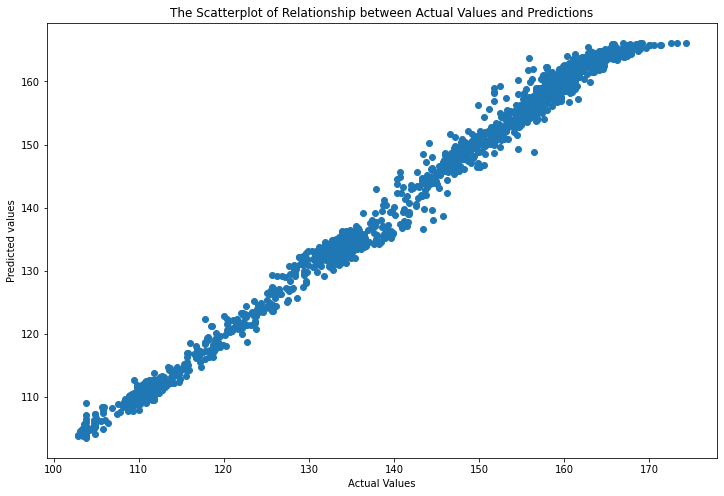

In [90]:
plt.figure(figsize=(12,8))
plt.xlabel("Actual Values")
plt.ylabel("Predicted values")
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.scatter(predictions_df['Actual'], predictions_df['Predicted'])

In [91]:
# We will evaluate our model performance by calculating the residual sum of squares and the explained variance score
from sklearn import metrics
print("MAE:",metrics.mean_absolute_error(y_test,y_predict_test))
print ("MSE:",metrics.mean_squared_error(y_test,y_predict_test))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_predict_test)))

MAE: 0.9364476311250454
MSE: 1.7463381216366118
RMSE: 1.3214908708109232


In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict_test = model.predict(x_test_scaled)
y_predict_train = model.predict(x_train_scaled) 
print('R2_score (train): ',r2_score(y_train, y_predict_train))
print('R2_score (test): ',r2_score(y_test, y_predict_test))

376/376 [==============================] - 0s 1ms/step
R2_score (train):  0.993216901738514
R2_score (test):  0.9931169900107104


In [93]:
#Evaluation of  the explained variance score (R^2)
print('This shows our model predict % {} of the target correctly'.format(np.round(metrics.explained_variance_score(y_test,y_predict_test)*100,2))) 

This shows our model predict % 99.31 of the target correctly


### Residual Analysis

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

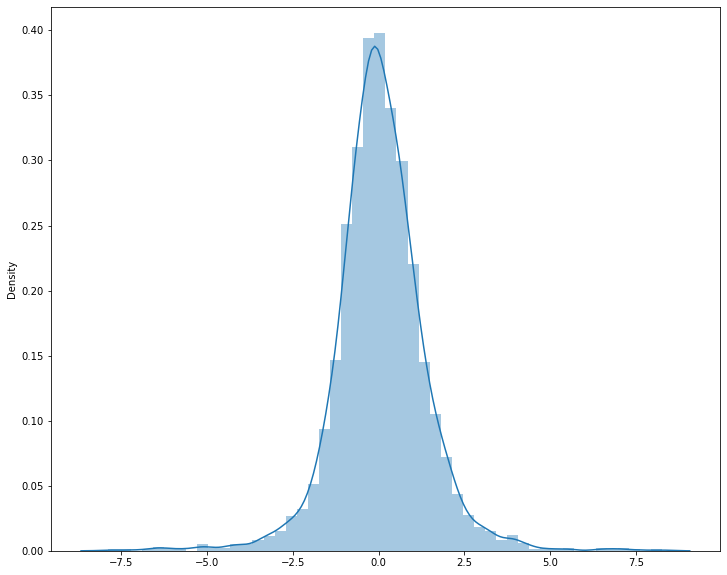

In [96]:
#Now we will visualize the differences between our predictions and actual y test data
plt.figure(figsize=(12,10))
sns.distplot(y_test-y_predict_test,bins=50) #this figure also proves that our model fits very good
#There is no huge differences between our predictions and actual y data

C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


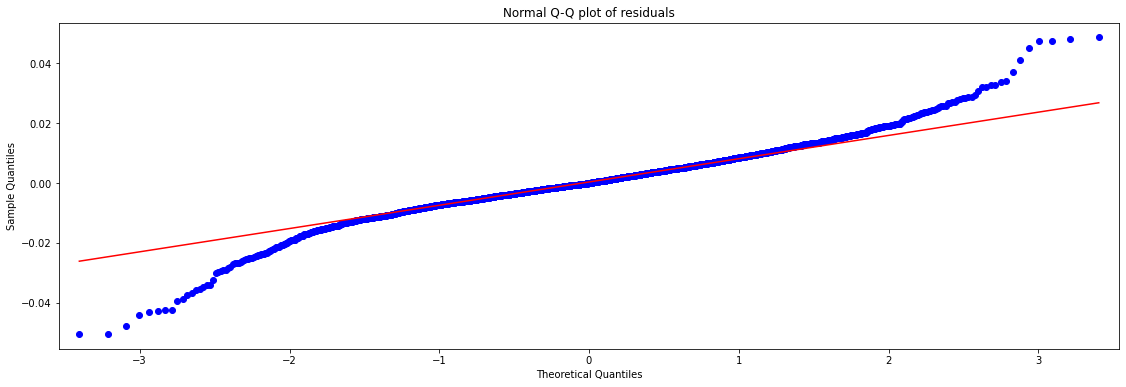

In [97]:
#Residuals values  = y - yhat
import statsmodels.api as smf
smf.qqplot(predictions_df['Error'], line = 'q')
plt.title('Normal Q-Q plot of residuals')
plt.show()